# Introduction
In this notebook, we will create an Elo rating system for tennis players and do some analysis on the choice of parameters. We find that a random choice of parameters actually does quite well, and that a wide variety of K-factor weight functions do a good job predicting the outcomes of tennis matches. In future notebooks, we will further expand upon this model by adding various features. 

# Background
The Elo rating system is designed to assign ratings to players which reflect their true strength at the game. Players are assigned an initial rating of 1. Before a match between two players, the system outputs a probability that one wins. After the match, the system updates each player's rating according to their previous ratings and the result of the match.  

Define $\sigma(x) = \exp(x) / (\exp(x) + 1)$, the logistic function, and let $K$ be a constant. If player one (p1) has rating $x$ and player two (p2) has rating $y$, the probability that p1 wins is given by $$\sigma(x-y).$$ Suppose $w=1$ if p1 wins and $w=0$ if p1 loses. After the match, the ratings are updated with the rule $$x \mapsto x + (-1)^{w+1} \sigma((-1)^w(x-y)),\quad y \mapsto y+(-1)^w \sigma((-1)^w (x-y)).$$  

Let's see why this makes any sense. Suppose we are starting from scratch and we want to develop this kind of rating system, but have no idea what the win probability and the update rule should be. Heuristically, it makes sense to suppose that $W,U$ are functions of the difference $x-y$ rather than the separate ratings $x,y$. Let $W(x-y)$ be the probability that p1 wins against p2, and let $U(x-y)$ be the update rule if p1 loses and $U(y-x)$ be the update rule if p1 wins, so that $$ x\mapsto x+(-1)^{w+1} U((-1)^w(x-y)),\quad y\mapsto y+(-1)^w U((-1)^w(x-y)). $$ We need $W$ and $U$ to satisfy some basic rules.  

First, $W(x-y) = 1-W(y-x)$ so $$W(z)+W(-z)=1.$$ 

Second, $$\lim_{x\to \infty} W(x)=1 \text{ and } \lim_{x\to-\infty} U(x) = 0.$$

Third and last, *the expected update of both players must be zero*. This is because the strengths of the players shouldn't actually change after a match, so the Elo rating (which is supposed to reflect true strength) shouldn't do that. Here, $w$ is the random quantity in question (make sure to distinguish between little $w$ and capital $W$: the relationship is that $W(x-y)$ should estimate $P(w=1)$). Expected update of both players equaling zero is $$ W(x-y) \cdot U(y-x) - W(y-x) \cdot U(x-y) = 0. $$ In other words, $$ \frac{W(z)}{W(-z)} = \frac{U(z)}{U(-z)}.$$  
In fact, these are the only real mathematical requirements for such a rating system. (See [Aldous](https://www.stat.berkeley.edu/~aldous/Papers/me-Elo-SS.pdf) for more details and assumptions.) As we see, an easy choice would be to set $KW=U$, where $K$ is any constant greater than zero. And really we may set $W$ to be any cdf, but logistic is the standard choice.  

In practice, the choice of $K$ is quite important, and the constant is called the *K-factor*, not to be confused with the tennis racquet line. This $K$ is the main subject of this note, and we will refer to it many times.  

Generally $K$ is taken to be a decreasing function of the number of matches that the updating player has played. In our case, following FiveThirtyEight's family of functions for $K$, we take $$K(n) = \frac{a}{(b+n)^c},$$ where $n$ is the number of matches played by that player before the match.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

np.random.seed(5142020) # today's date!

def sigmoid(z):
    '''The sigmoid function.'''
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))

We will use [Jeff Sackmann](http://jeffsackmann.com)'s immense trove of tennis data; see his [GitHub page](https://github.com/JeffSackmann).

In [4]:
class Elo(object):
    
    def __init__(self, start_year, end_year, rand_init = True):
        
        self.start_year = start_year
        self.end_year = end_year
        
        if rand_init:
            self.params = np.zeros(3)
            self.params[0] = np.random.random() * 2
            self.params[1] = np.random.random() * 3 + 2
            self.params[2] = np.random.random()
        else:
            self.params = [1.44, 5, 0.4]
            
        self.data = []
        for i in range(start_year, end_year + 1):
            self.data.append(pd.read_csv('./atp/atp_matches_' + str(i) + '.csv'))
        
        # collect all the player names
        self.players = {player for player in self.data[0]['winner_name']}
        self.players = self.players.union({player for player in self.data[0]['loser_name']})
        for i in range(1, end_year - start_year + 1):
            self.players = self.players.union({player for player in self.data[i]['winner_name']})
            self.players = self.players.union({player for player in self.data[i]['loser_name']})            
            
        # ratings are of the form (n, r)
        # where n is the number of matches the player has played
        # and r is their rating.
        self.ratings = {player: (0, 1.0) for player in self.players}
    
    def randomize_params(self):
        self.params[0] = np.random.random() * 2
        self.params[1] = np.random.random() * 3 + 2
        self.params[2] = np.random.random()
    
    def get_params(self):
        return self.params.copy()
    
    def set_params(self, p):
        self.params = p
    
    def k(self, n):
        '''returns the K-factor, which dictates how sensitive ratings are
        to an individual match and depends on the number of matches played.'''
        return self.params[0] * (self.params[1] + n)**(-self.params[2])
    
    
    def update_one(self, x, y, n1, n2):
        '''this function updates one match. 'x','y' are the ratings of
        the winner and loser respectively, 'n1','n2' are the number of matches
        that the winner and loser have played respectively. Returns the
        prior probability that the winner wins, and the values to update 
        the ratings by. '''
        z = sigmoid(y-x)
        u1 = self.k(n1) * z
        u2 = -self.k(n2) * z
        prob = 1-z

        return(prob, u1, u2)
        
    def update_ratings(self, compute_cost_start_year):
        '''this function updates the ratings of all players in the time frame
        between start_year and end_year. We begin computing log-loss at the
        beginning of compute_cost_start_year.
        'method' can be ll = log loss error, or wp = win prediction. '''
        # first reset the ratings.
        self.ratings = {player: (0, 1.0) for player in self.players}
        
        cost = 0
        win_pred = 0
        
        for i in range(len(self.data)):
            for j, row in self.data[i].iterrows():
                
                winner = row['winner_name']
                loser = row['loser_name']
                
                # get ratings.
                wnm, wrating = self.ratings[winner]
                lnm, lrating = self.ratings[loser]
                
                # update.
                prob, u1, u2 = self.update_one(wrating, lrating, wnm, lnm)
                self.ratings[winner] = wnm + 1, wrating + u1
                self.ratings[loser] = lnm + 1, lrating + u2
                
                # compute log-loss error or win prediction percentage.
                if(i + self.start_year >= compute_cost_start_year):
                    cost -= np.log(prob)
                    win_pred += (prob > 0.5)
        
        # figure out what to divide cost by.
        num_rows = 0
        for i in range(min(len(self.data), self.end_year + 1 - compute_cost_start_year)):
            num_rows += len(self.data[self.end_year - self.start_year - 1 + i])

        return (cost / num_rows, win_pred / num_rows)
    

Now we do a little bit of analysis. You may notice that I chose to work with the natural base rather than base-10 with some weird 400 multiplicative factor like with regular Elo ratings. The only difference between these ratings on this notebook and the ratings you may see on FiveThirtyEight or Jeff Sackmann's website is a multiplicative factor of $400/\ln 10\approx 173.72$ (see Appendix). There is also an additive factor, but we can ignore that because Elo ratings give the same predictions when the same value is added to all ratings (and all initial ratings). 

[FiveThirtyEight](https://fivethirtyeight.com/features/serena-williams-and-the-difference-between-all-time-great-and-greatest-of-all-time/)'s parameter choices were $$[250/174, 5, 0.4] \approx [1.44, 5, 0.4].$$ Let's test their model with a small and large amount of history. 

In [5]:
elo_538 = Elo(2013,2014)
elo_538.set_params([1.44, 5, 0.4])
cost, win_pred = elo_538.update_ratings(2014)
print("One year of history:")
print("log-loss=" + str(cost) + ", win prediction=" + str(win_pred) + "\n")

elo_538 = Elo(2000,2014)
elo_538.set_params([1.44, 5, 0.4])
cost, win_pred = elo_538.update_ratings(2014)
print("14 years of history:")
print("log-loss=" + str(cost) + ", win prediction=" + str(win_pred))

One year of history:
log-loss=0.6014581173012675, win prediction=0.649796195652174

14 years of history:
log-loss=0.5851314185434491, win prediction=0.6688179347826086


I got the same log-loss error that [Kovalchik](https://core.ac.uk/download/pdf/86638968.pdf) got, but I got a different win prediction. I'm not entirely certain how that happened, since I think we used the same data set. I'm gonna have to go on with what I have.

# Sensitivity of Ratings
My main observation for this post is that ratings are not very sensitive to the parameters because 1) the model itself is pretty robust, and 2) there are some redundancies to our three parameters.

We will initialize an object of class Elo with parameters $p$ which are obtained from the following distribution: 

$$ p \sim \text{Unif}([0,2]\times[2,5]\times[0,1]). $$

We will calculate both log-loss error and win prediction rates for 100 models with random parameters drawn from the above distribution, then we will improve upon it below. We will only take one year of history for the sake of computation speed.

progress bar: 0.0
progress bar: 0.1
progress bar: 0.2
progress bar: 0.3
progress bar: 0.4
progress bar: 0.5
progress bar: 0.6
progress bar: 0.7
progress bar: 0.8
progress bar: 0.9


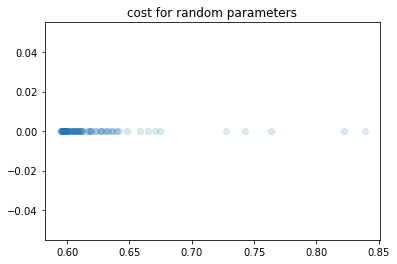

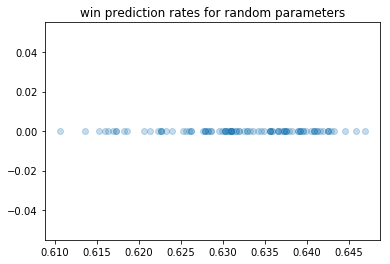

In [6]:
elo = Elo(2012,2013)
costs = []
win_preds = []
rand_params = []
n = 100

for i in range(n):
    elo.randomize_params()
    cost, win_pred = elo.update_ratings(2013)
    costs.append(cost)
    win_preds.append(win_pred)
    rand_params.append(elo.get_params())
    
    if i % 10 == 0:
        print('progress bar:', i/n)

plt.plot(costs,np.zeros(n),'o', alpha=0.15)
plt.title('cost for random parameters')
plt.show()

plt.plot(win_preds,np.zeros(n),'o', alpha=0.25)
plt.title('win prediction rates for random parameters')
plt.show()

Most parameters drawn from this simple uniform distribution do pretty well. The log-loss error is actually concentrated near the minimum around 0.60, which is quite interesting. **So a "typical" set of parameters achieves near-minimum log-loss error**. Note that 0.60 was the log-loss error achieved by the handpicked FiveThirtyEight parameters.

# You bring your best ten, I'll bring mine

But perhaps win prediction rate is what you care about more. In that case, the concentration is less extreme and there is merely a skew towards the optimal win prediction rate. The handpicked parameters seem to do a little bit better with a WPR of 0.649. Of course, the random parameters were tested on 2012-2013 data. To make sure, from the 100 random sets of parameters above, let's pick the best 10 and run it against 2013-2014 data.

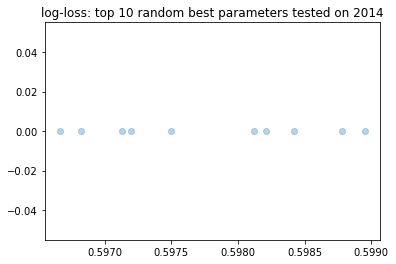

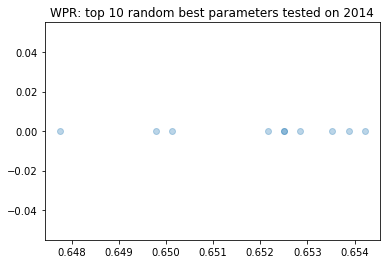

In [9]:
df = pd.DataFrame({'p' : rand_params, 'c' : costs})
df_top10 = df.sort_values(by='c')[0:10]
cs = df_top10['c'].to_numpy()
params_top10 = np.array(list(df_top10['p'].to_numpy())) # I could avoid this if I split up params in the data frame
elo2 = Elo(2013, 2014)
new_costs = []
new_win_preds = []

for p in params_top10:
    elo2.set_params(p)
    cost, win_pred = elo2.update_ratings(2014)
    new_costs.append(cost)
    new_win_preds.append(win_pred)
    
plt.plot(new_costs,np.zeros(10),'o', alpha=0.3)
plt.title('log-loss: top 10 random best parameters tested on 2014')
plt.show()

plt.plot(new_win_preds,np.zeros(10),'o', alpha=0.3)
plt.title('WPR: top 10 random best parameters tested on 2014')
plt.show()

We see that actually, most of the top 10 sets of parameters do even **better** than the handpicked FiveThirtyEight set of parameters with respect to both log-loss error and win prediction rate. So this Elo model is very robust, and there is a wide range of parameters which can all generate pretty good predictions. 

# Correlations

First we make observations about the correlations between the coordinates for the top 10 parameters.

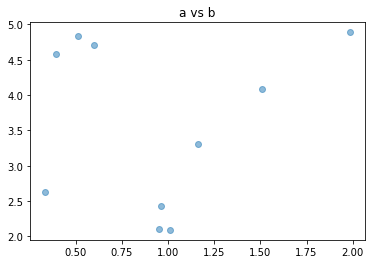

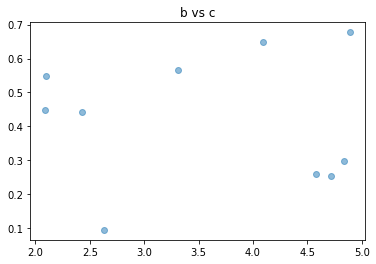

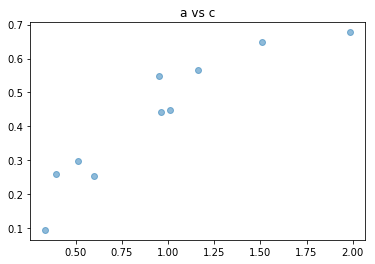

In [10]:
plt.plot(params_top10[:,0],params_top10[:,1],'o', alpha=0.5)
plt.title("a vs b")
plt.show()
plt.plot(params_top10[:,1], params_top10[:,2], 'o', alpha=0.5)
plt.title("b vs c")
plt.show()
plt.plot(params_top10[:,0],params_top10[:,2], 'o', alpha=0.5)
plt.title("a vs c")
plt.show()

We'll refer to the first, second, and third parameters as $a,b,c$. Recall that the K-factor function is 

$$f(n) = \frac{a}{(b+n)^c}$$  
where $n$ is the number of matches played by that player. We see that $b$ seems to be independent of $a,c$, but it is clear that there is some relationship between $a$ and $c$. It makes sense because for a fixed $n$, a large $a$ and large $c$ will give the same result as a small $a$ and small $c$. 

# The best K-factor functions
Let's now see if these parameters give rise to truly different K-factor weight functions or the redundancies in the parameters allow for quite different parameters but similar K-factor weight functions.

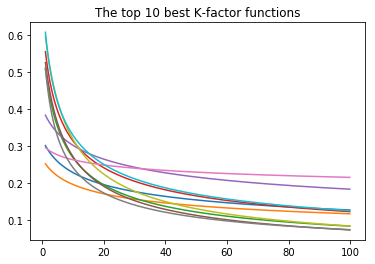

In [11]:
x = np.arange(1,100, 0.1)
def f(a,b,c,n):
    return (a/np.power(b+n, c))
for p in params_top10:
    a,b,c = p
    plt.plot(x, f(a,b,c,x))
plt.title("The top 10 best K-factor functions")
plt.show()

It seems to me that the K-factor functions above are quite different with respect to many metrics. Certainly the light blue curve and the orange curve are quite different, yet they both yield pretty good predictions.

# Preliminary conclusions
First, this analysis casts doubt on my initial feeling that there is one "true" K-factor function that we wish to approximate. It seems that many quite different K-factor functions can be used for prediction quite effectively and as near-optimally as you can get with this model.

Second, I believe that a random choice of parameters is a better one than a handpicked one, from an algorithmic point of view. It separates the parameters from most human fiddling (except the distributions that we pick from, which was pretty generic -- a uniform distribution on a large 3-d box). 

Third, the fact that many different K-factor functions work opens up a new frontier of prediction with Elo. Can we use, say, ten different Elo models at once to make a better prediction than any one of them can? 

For a fun conclusion, let's run our best parameters against more years of data. Recall that with 14 years of data, FiveThirtyEight's parameters achieved a log-loss error of 0.585 and a win prediction rate of 0.669.

In [62]:
elo3 = Elo(2000, 2014)
avg_cost = 0
avg_wp = 0
for p in params_top10:
    cost, win_pred = elo3.update_ratings(2014)
    avg_cost += cost
    avg_wp += win_pred
print("avg log-loss=" + str(avg_cost/10) + ", avg wpr=" + str(avg_wp/10))

avg log-loss=0.5843253144672759, avg wpr=0.662703804347826


Note also that training on only 1 year of previous history means that the number of matches of a player most likely does not reflect the actual number of matches of that player. So if we wanted to do this better, we might pick parameters that performed well on many years of history. But the computation takes too long (it already takes too long).

## Appendix

For the standard Elo rating, the win probability of player with rating $x$ (who is facing a player with rating $y$) is $$ \frac{1}{1+10^{(y-x)/400}} = \frac{1}{1+ \exp\left(\frac{\ln 10}{400}(y-x)\right)} $$
So we have to multiply our ratings by $400/\ln 10\approx 173.72$ to get the standard Elo ratings. There's also an additive factor of $1000-173.72$ because generally the tennis ratings start at 1000, and we start at 1.